In [3]:
import os
import shutil
import torch
import numpy as np
import SimpleITK as sitk
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ToTensord, ResizeD,
    RandAffineD,  # Elastic deformation removed because it's not available in this MONAI version.
    RandGaussianNoiseD, RandAdjustContrastD
)

# Delete existing folders to avoid overlapping data.
shutil.rmtree('./dataset/train_new', ignore_errors=True)
shutil.rmtree('./dataset/val_new', ignore_errors=True)

# -----------------------------
# Define Augmentation Transforms for Training (Offline)
# -----------------------------
augmentation_transforms = Compose([
    # Small random affine transformation.
    RandAffineD(
        keys=["image", "label"],
        prob=1.0,
        rotate_range=(np.pi/18, np.pi/18, 0),  # up to ~10° rotation in-plane
        translate_range=(10, 10, 0),
        scale_range=(0.1, 0.1, 0),
        mode=("bilinear", "nearest"),
    ),
    # Uncomment if a suitable elastic deformation transform is available.
    # RandElasticDeformationD(
    #     keys=["image", "label"],
    #     prob=1.0,
    #     sigma_range=(5, 7),
    #     magnitude_range=(10, 15),
    #     mode=("bilinear", "nearest"),
    # ),
    # Add Gaussian noise.
    RandGaussianNoiseD(
        keys=["image"],
        prob=1.0,
        mean=0.0,
        std=0.1,
    ),
    # Adjust contrast.
    RandAdjustContrastD(
        keys=["image"],
        prob=1.0,
        gamma=(0.9, 1.1),
    )
])

# -----------------------------
# Base Processing Transforms (for both training and validation)
# -----------------------------
base_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(352, 352)),
    ToTensord(keys=["image", "label"]),
])

# -----------------------------
# 1. Prepare the 2D Datasets from Original Folders
# -----------------------------
train_2d_dir = './dataset/train_2d'
val_2d_dir = './dataset/val_2d'

train_data_2d = []
for patient in os.listdir(train_2d_dir):
    patient_path = os.path.join(train_2d_dir, patient)
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith('.nii') and '_gt' not in file:
                image_path = os.path.join(patient_path, file)
                if '_slice' in file:
                    parts = file.split('_slice')
                    gt_file = parts[0] + '_gt_slice' + parts[1]
                else:
                    gt_file = file.replace('.nii', '_gt.nii')
                gt_path = os.path.join(patient_path, gt_file)
                if os.path.exists(gt_path):
                    train_data_2d.append({"image": image_path, "label": gt_path})
                else:
                    print("Warning: No corresponding ground truth for", image_path)
print(f"Found {len(train_data_2d)} 2D training samples.")

val_data_2d = []
for patient in os.listdir(val_2d_dir):
    patient_path = os.path.join(val_2d_dir, patient)
    if os.path.isdir(patient_path):
        for file in os.listdir(patient_path):
            if file.endswith('.nii') and '_gt' not in file:
                image_path = os.path.join(patient_path, file)
                if '_slice' in file:
                    parts = file.split('_slice')
                    gt_file = parts[0] + '_gt_slice' + parts[1]
                else:
                    gt_file = file.replace('.nii', '_gt.nii')
                gt_path = os.path.join(patient_path, gt_file)
                if os.path.exists(gt_path):
                    val_data_2d.append({"image": image_path, "label": gt_path})
                else:
                    print("Warning: No corresponding ground truth for", image_path)
print(f"Found {len(val_data_2d)} 2D validation samples.")

# -----------------------------
# 2. Create New Folders for Processed Data (Augmented Training & Non-Augmented Validation)
# -----------------------------
new_train_dir = './dataset/train_new'
new_val_dir = './dataset/val_new'
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_val_dir, exist_ok=True)

def save_tensor_as_nifti(tensor, out_path):
    """Save a tensor as a Nifti file using SimpleITK."""
    arr = tensor.cpu().numpy()
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr[0]
    img = sitk.GetImageFromArray(arr)
    sitk.WriteImage(img, out_path)

# -----------------------------
# 3. Process and Save Training Samples (Original + Augmented)
# -----------------------------
num_augments = 3  # Number of augmented copies to create per sample

for sample in train_data_2d:
    patient_name = os.path.basename(os.path.dirname(sample["image"]))
    patient_out_dir = os.path.join(new_train_dir, patient_name)
    os.makedirs(patient_out_dir, exist_ok=True)
    
    sample_dict = {"image": sample["image"], "label": sample["label"]}
    data = base_transforms(sample_dict)
    base_name = os.path.basename(sample["image"]).replace('.nii', '')
    out_image_path = os.path.join(patient_out_dir, base_name + ".nii")
    out_label_path = os.path.join(patient_out_dir, base_name + "_gt.nii")
    save_tensor_as_nifti(data["image"], out_image_path)
    save_tensor_as_nifti(data["label"], out_label_path)
    
    # Generate augmented copies.
    for i in range(num_augments):
        aug_data = augmentation_transforms(data)
        aug_image_path = os.path.join(patient_out_dir, base_name + f"_aug{i}.nii")
        aug_label_path = os.path.join(patient_out_dir, base_name + f"_gt_aug{i}.nii")
        save_tensor_as_nifti(aug_data["image"], aug_image_path)
        save_tensor_as_nifti(aug_data["label"], aug_label_path)

# -----------------------------
# 4. Process and Save Validation Samples (Non-Augmented Only)
# -----------------------------
for sample in val_data_2d:
    patient_name = os.path.basename(os.path.dirname(sample["image"]))
    patient_out_dir = os.path.join(new_val_dir, patient_name)
    os.makedirs(patient_out_dir, exist_ok=True)
    
    sample_dict = {"image": sample["image"], "label": sample["label"]}
    data = base_transforms(sample_dict)
    base_name = os.path.basename(sample["image"]).replace('.nii', '')
    out_image_path = os.path.join(patient_out_dir, base_name + ".nii")
    out_label_path = os.path.join(patient_out_dir, base_name + "_gt.nii")
    save_tensor_as_nifti(data["image"], out_image_path)
    save_tensor_as_nifti(data["label"], out_label_path)

print("Preprocessing with augmentation complete.")


Found 1526 2D training samples.
Found 376 2D validation samples.
Preprocessing with augmentation complete.


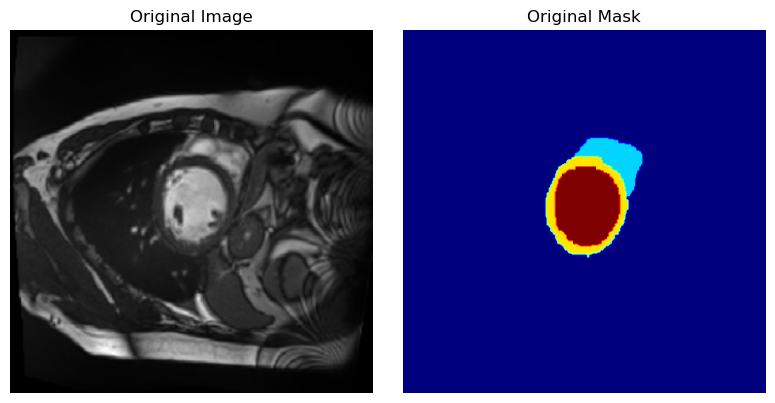

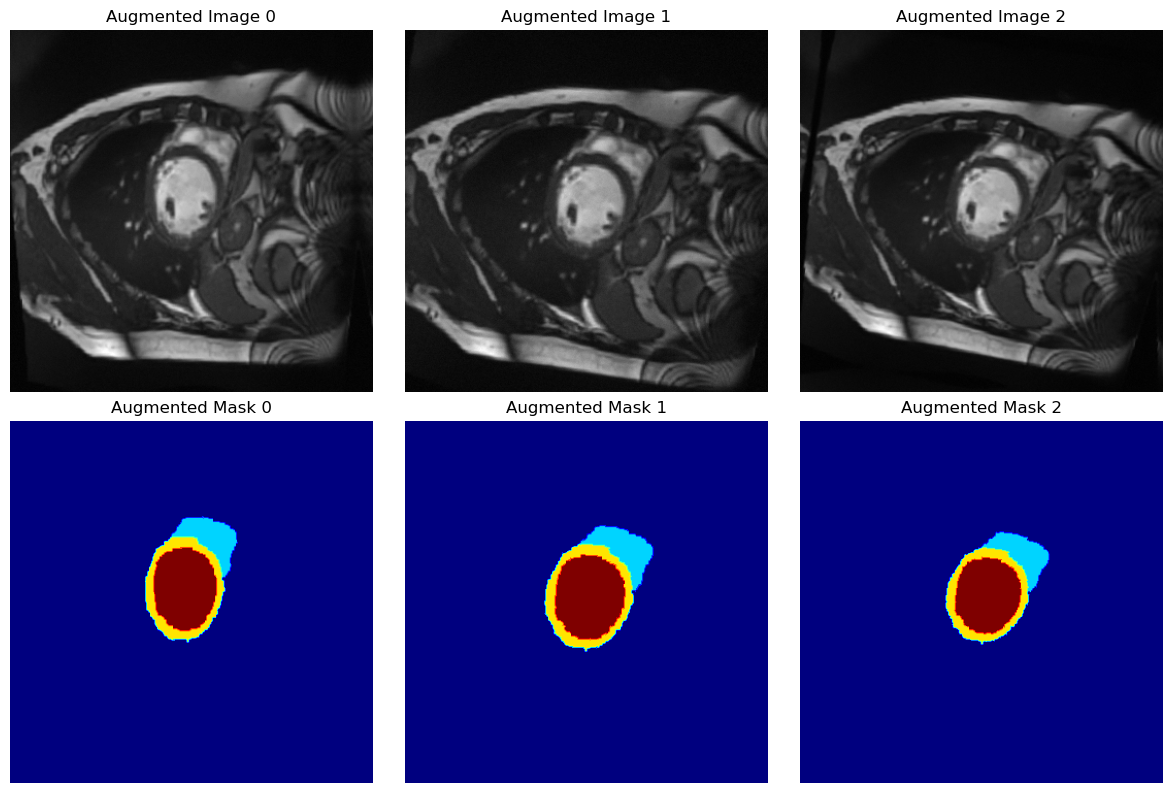

In [6]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Set the folder for the new training data.
train_new_dir = './dataset/train_new'

# Choose a specific patient folder, e.g. "patient001"
patient = 'patient001'
patient_dir = os.path.join(train_new_dir, patient)

# Choose a base filename for a particular slice, for example:
# Original image: patient001_frame01_slice00.nii
# Original ground truth: patient001_frame01_slice00_gt.nii
base_name = 'patient001_frame01_slice04'

# Build paths for the original (non-augmented) image and label.
orig_image_path = os.path.join(patient_dir, base_name + ".nii")
orig_label_path = os.path.join(patient_dir, base_name + "_gt.nii")

# Check if the original files exist.
if not os.path.exists(orig_image_path) or not os.path.exists(orig_label_path):
    raise FileNotFoundError("Original files not found.")

# Load the original image and label.
orig_img = sitk.ReadImage(orig_image_path)
orig_lbl = sitk.ReadImage(orig_label_path)
orig_img_arr = sitk.GetArrayFromImage(orig_img)
orig_lbl_arr = sitk.GetArrayFromImage(orig_lbl)

# Number of augmented copies to show (e.g., 3)
num_augments = 3
aug_image_paths = []
aug_label_paths = []
for i in range(num_augments):
    aug_img_path = os.path.join(patient_dir, base_name + f"_aug{i}.nii")
    aug_lbl_path = os.path.join(patient_dir, base_name + f"_gt_aug{i}.nii")
    if os.path.exists(aug_img_path) and os.path.exists(aug_lbl_path):
        aug_image_paths.append(aug_img_path)
        aug_label_paths.append(aug_lbl_path)

# Plot original image and mask.
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(orig_img_arr, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(orig_lbl_arr, cmap="jet")
plt.title("Original Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

# Plot augmented images and their masks.
if len(aug_image_paths) > 0:
    n = len(aug_image_paths)
    fig, axs = plt.subplots(2, n, figsize=(4*n, 8))
    for i in range(n):
        # Load augmented image and label.
        aug_img = sitk.ReadImage(aug_image_paths[i])
        aug_lbl = sitk.ReadImage(aug_label_paths[i])
        aug_img_arr = sitk.GetArrayFromImage(aug_img)
        aug_lbl_arr = sitk.GetArrayFromImage(aug_lbl)
        
        axs[0, i].imshow(aug_img_arr, cmap="gray")
        axs[0, i].set_title(f"Augmented Image {i}")
        axs[0, i].axis("off")
        
        axs[1, i].imshow(aug_lbl_arr, cmap="jet")
        axs[1, i].set_title(f"Augmented Mask {i}")
        axs[1, i].axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No augmented files found for this slice.")
